# Data Preparation

In [1]:
import numpy as np # fundamental package for scientific computing in Python.
import pandas as pd # data manipulation and analysis
import matplotlib.pyplot as plt
import seaborn as sns
import plotly.express as px # data visualization library

In [2]:
# Read in CSV data to Dataframe
df = pd.read_csv('AAPL.csv')
saved_df = df.copy(deep = True) # create copy of orginal dataframe

# Drop Multiple Columns (not required for this analysis)
df = df.drop(['Open','High','Low','Adj Close'], axis=1)

# subset of data
df = df.iloc[8000:-1]
df.reset_index(inplace=True) # Reset the index to default integer index

#
df

,index,Date,Close,Volume
0,8000,2012-08-29,96.209999,50701700
1,8001,2012-08-30,94.838570,75674900
2,8002,2012-08-31,95.034286,84580300
3,8003,2012-09-04,96.424286,91973000
4,8004,2012-09-05,95.747147,84093800
...,...,...,...,...
1903,9903,2020-03-25,245.520004,75900500
1904,9904,2020-03-26,258.440002,63021800
1905,9905,2020-03-27,247.740005,51054200
1906,9906,2020-03-30,254.809998,41994100


# Feature Engineering

Trend Indicators

- Price
- Price Change
- Price Change Direction
- SMA
- Difference (price & sma)
- CMA
- 50_EMA (day)
- 200_EMA (day)
- Short_ema
- Long_ema
- MACD
- Signal
- MACD difference SIGNAL
- RSI (Relative Strength Index)
- RSI Change Direction

In [3]:
# Price Change + Direction
df['closing_price_change'] = df['Close'].diff() # difference between the values in current row and previous row
df['pct_change'] = df['Close'].pct_change()
vals = [] # empty list
for value in df['closing_price_change']:
    if (value >= 0):
        vals.append(1)
    else:
        vals.append(0)           
df['price_change_direction'] = vals # Postive v Negative (Trend Direction)


# Moving Averages
df['SMA'] = df.Close.rolling(window=10).mean() # SMA -->> simple moving average (SMA)
df['price_difference_sma'] = df['Close'] - df['SMA'] # SMA difference RL (price)
df['CMA'] = df.iloc[:,2].expanding(min_periods=10).mean() # -->> cumaltive moving average (CMA)
df['50ema'] = df.iloc[:,2].ewm(span=50,adjust=False).mean() # -->> exponential moving average (50 day EMA) (weight on recent prices)
df['200ema'] = df.iloc[:,2].ewm(span=200,adjust=False).mean() # -->> exponential moving average (200 day EMA) (weight on recent prices)


# Moving Average Convergence Divergence (MACD)
df['short_ema'] = df.Close.ewm(span=12,adjust=False).mean() # -->> short EMA
df['long_ema'] = df.Close.ewm(span=26,adjust=False).mean() # -->> short EMA
df['macd'] = df.short_ema - df.long_ema # -->> macd line
df['signal'] = df.macd.ewm(span=9,adjust=False).mean() # -->> signal
df['macd_difference_signal'] = df.macd - df.signal
mds = [] # empty list
for value in df['macd_difference_signal']:
    if (value >= 0):
        mds.append("positive")
    else:
        mds.append("negative")           
df['mds_direction'] = mds # Postive v Negative (Trend Direction)


# Relative Strenght Index (RSI)
delta = df['Close'].diff()
gain = (delta.where(delta>0,0)).rolling(window=14).mean() # average gains (MAs)
loss = (-delta.where(delta<0,0)).rolling(window=14).mean() # average losses (MAs)
rs = gain/loss # RS = avg_gains/avg_losses
rsi = 100 - (100/(1+rs))
df['RSI'] = rsi # rsi value
df['rsi_change'] = df.RSI.diff() # rsi_change()
#
#  RSI direction change
rsi_c = [] # empty list
for val in df['rsi_change']:
    if (val>= 0):
        rsi_c.append(1)
    else:
        rsi_c.append(0)           
df['rsi_change_direction'] = rsi_c # Postive v Negative (Trend Direction)
#
# RSI overbought v oversold flag
indicator = []
for i in range(len(df)):
    if df['RSI'][i] > 70:
        indicator.append("RSI_overbought_indicator")
    elif df['RSI'][i] < 30:
        indicator.append("RSI_oversold_indicator")
    else:
       indicator.append(np.nan)
df['rsi_indicator'] = indicator


# Bollingor Bands (SMA, UpperBand + LowerBand)
df['bollingor_band_sma'] = df['Close'].rolling(window=20).mean() # Calculate the 20-period Simple Moving Average (SMA)
df['bb_sma_std'] = df['Close'].rolling(window=20).std() # Calculate the 20-period Standard Deviation (SD)
df['bb_upper_band'] = df['bollingor_band_sma'] + 2 * df['bb_sma_std'] # Calculate the Upper Bollinger Band (UB) x2 std above
df['bb_lower_band'] = df['bollingor_band_sma'] - 2 * df['bb_sma_std'] # Calculate the Lower Bollinger Band (LB) x2 std below

df

,index,Date,Close,Volume,closing_price_change,pct_change,price_change_direction,SMA,price_difference_sma,CMA,...,short_ema,long_ema,macd,signal,macd_difference_signal,mds_direction,RSI,rsi_change,rsi_change_direction,rsi_indicator
0,8000,2012-08-29,96.209999,50701700,NaN,NaN,0,NaN,NaN,NaN,...,96.209999,96.209999,0.000000,0.000000,0.000000,positive,NaN,NaN,0,NaN
1,8001,2012-08-30,94.838570,75674900,-1.371429,-0.014255,0,NaN,NaN,NaN,...,95.999010,96.108412,-0.109402,-0.021880,-0.087521,negative,NaN,NaN,0,NaN
2,8002,2012-08-31,95.034286,84580300,0.195717,0.002064,1,NaN,NaN,NaN,...,95.850591,96.028847,-0.178256,-0.053155,-0.125100,negative,NaN,NaN,0,NaN
3,8003,2012-09-04,96.424286,91973000,1.389999,0.014626,1,NaN,NaN,NaN,...,95.938852,96.058139,-0.119287,-0.066382,-0.052905,negative,NaN,NaN,0,NaN
4,8004,2012-09-05,95.747147,84093800,-0.677139,-0.007022,0,NaN,NaN,NaN,...,95.909359,96.035102,-0.125744,-0.078254,-0.047489,negative,NaN,NaN,0,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1903,9903,2020-03-25,245.520004,75900500,-1.360001,-0.005509,0,245.873001,-0.352997,136.067925,...,251.573397,268.647866,-17.074468,-15.210790,-1.863679,negative,38.796443,1.491896,1,NaN
1904,9904,2020-03-26,258.440002,63021800,12.919998,0.052623,1,246.894002,11.546001,136.132163,...,252.629798,267.891728,-15.261930,-15.221018,-0.040912,negative,43.065694,4.269251,1,NaN
1905,9905,2020-03-27,247.740005,51054200,-10.699997,-0.041402,0,243.871002,3.869003,136.190719,...,251.877522,266.399008,-14.521485,-15.081111,0.559626,positive,45.578425,2.512731,1,NaN
1906,9906,2020-03-30,254.809998,41994100,7.069992,0.028538,1,245.131001,9.678996,136.252921,...,252.328672,265.540563,-13.211890,-14.707267,1.495377,positive,42.224034,-3.354391,0,NaN


In [4]:
df.describe()

,index,Close,Volume,closing_price_change,pct_change,price_change_direction,SMA,price_difference_sma,CMA,50ema,200ema,short_ema,long_ema,macd,signal,macd_difference_signal,RSI,rsi_change,rsi_change_direction
count,1908.000000,1908.000000,1.908000e+03,1907.000000,1907.000000,1908.000000,1899.000000,1899.000000,1899.000000,1908.000000,1908.000000,1908.000000,1908.000000,1908.000000,1908.000000,1908.000000,1895.000000,1894.000000,1908.000000
mean,8953.500000,136.314785,5.322467e+07,0.082895,0.000662,0.520964,136.143960,0.363409,96.550274,134.005257,127.953500,135.863888,135.210899,0.652989,0.682719,-0.029730,55.142627,-0.010740,0.501048
std,550.936475,57.983803,3.972044e+07,2.956383,0.017422,0.499691,57.729574,4.366528,17.961275,54.977404,47.095303,57.497301,56.669769,3.235971,3.022774,0.835072,18.227160,6.707356,0.500130
min,8000.000000,55.790001,1.136200e+07,-35.759995,-0.128647,0.000000,58.104428,-34.725995,71.378026,61.061410,68.637546,58.716132,60.117008,-18.660071,-15.221018,-6.392161,8.212766,-35.215547,0.000000
25%,8476.750000,94.982498,2.693312e+07,-0.820000,-0.007031,0.000000,95.288499,-1.423929,81.126198,96.104930,91.560527,95.718841,96.067684,-0.690692,-0.645103,-0.378907,41.863132,-4.163218,0.000000
50%,8953.500000,118.715000,4.018980e+07,0.074287,0.000524,1.000000,117.717000,0.553712,93.705805,116.413916,113.923168,117.488379,116.855018,0.710150,0.726190,0.002181,54.706446,0.067995,1.000000
75%,9430.250000,173.970001,6.614158e+07,1.156429,0.009409,1.000000,172.901498,2.546360,109.896771,171.699817,165.210810,172.523312,171.827688,2.297510,2.160811,0.432327,69.337279,3.971694,1.000000
max,9907.000000,327.200012,3.652131e+08,29.740005,0.119808,1.000000,322.748999,14.834995,136.314785,304.598888,257.917871,321.353437,316.212138,11.402984,10.814904,2.926911,95.930620,39.919924,1.000000


# Data Visualiation

In [5]:
check = []

for i in range(len(df)):
    if df['macd'][i] == df['signal'][i]:
        check.append(df['macd'][i])
    else:
        check.append(np.nan)

#Create DataFrame including all above features and randomly generated data
strategy = pd.DataFrame ({'Date':df.Date,'Price':df.Close,'MACD':df.macd,'SIGNAL':df.signal,
                          'trigger':check,'50_ema':df['50ema'],'200_ema':df['200ema']})
strategy


,Date,Price,MACD,SIGNAL,trigger,50_ema,200_ema
0,2012-08-29,96.209999,0.000000,0.000000,0.0,96.209999,96.209999
1,2012-08-30,94.838570,-0.109402,-0.021880,NaN,96.156218,96.196353
2,2012-08-31,95.034286,-0.178256,-0.053155,NaN,96.112220,96.184790
3,2012-09-04,96.424286,-0.119287,-0.066382,NaN,96.124458,96.187173
4,2012-09-05,95.747147,-0.125744,-0.078254,NaN,96.109662,96.182795
...,...,...,...,...,...,...,...
1903,2020-03-25,245.520004,-17.074468,-15.210790,NaN,279.935960,256.656468
1904,2020-03-26,258.440002,-15.261930,-15.221018,NaN,279.092981,256.674214
1905,2020-03-27,247.740005,-14.521485,-15.081111,NaN,277.863453,256.585317
1906,2020-03-30,254.809998,-13.211890,-14.707267,NaN,276.959396,256.567652


##### Moving Averages

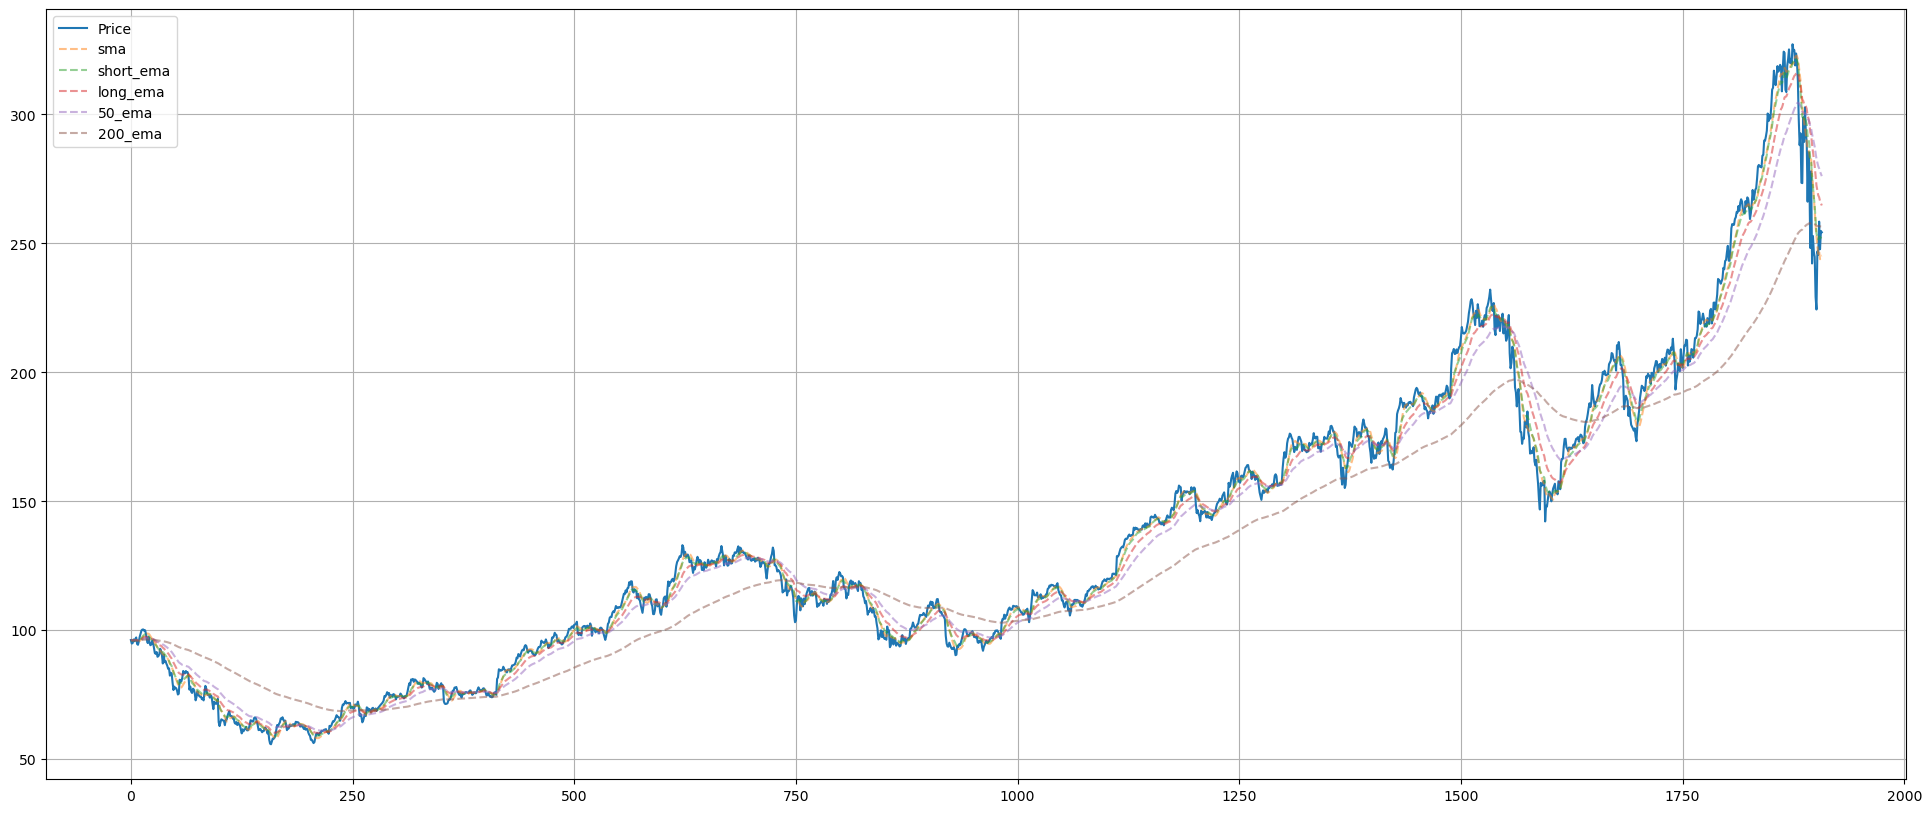

In [8]:
plt.figure(figsize=[24,10])
plt.grid(True)
plt.plot(df['Close'],label='Price')
plt.plot(df['SMA'],label='sma',alpha=0.5,linestyle='--')
plt.plot(df['short_ema'],label='short_ema',alpha=0.5,linestyle='--')
plt.plot(df['long_ema'],label='long_ema',alpha=0.5,linestyle='--')
plt.plot(df['50ema'],label='50_ema',alpha=0.5,linestyle='--')
plt.plot(df['200ema'],label='200_ema',alpha=0.5,linestyle='--')
plt.legend(loc=2)

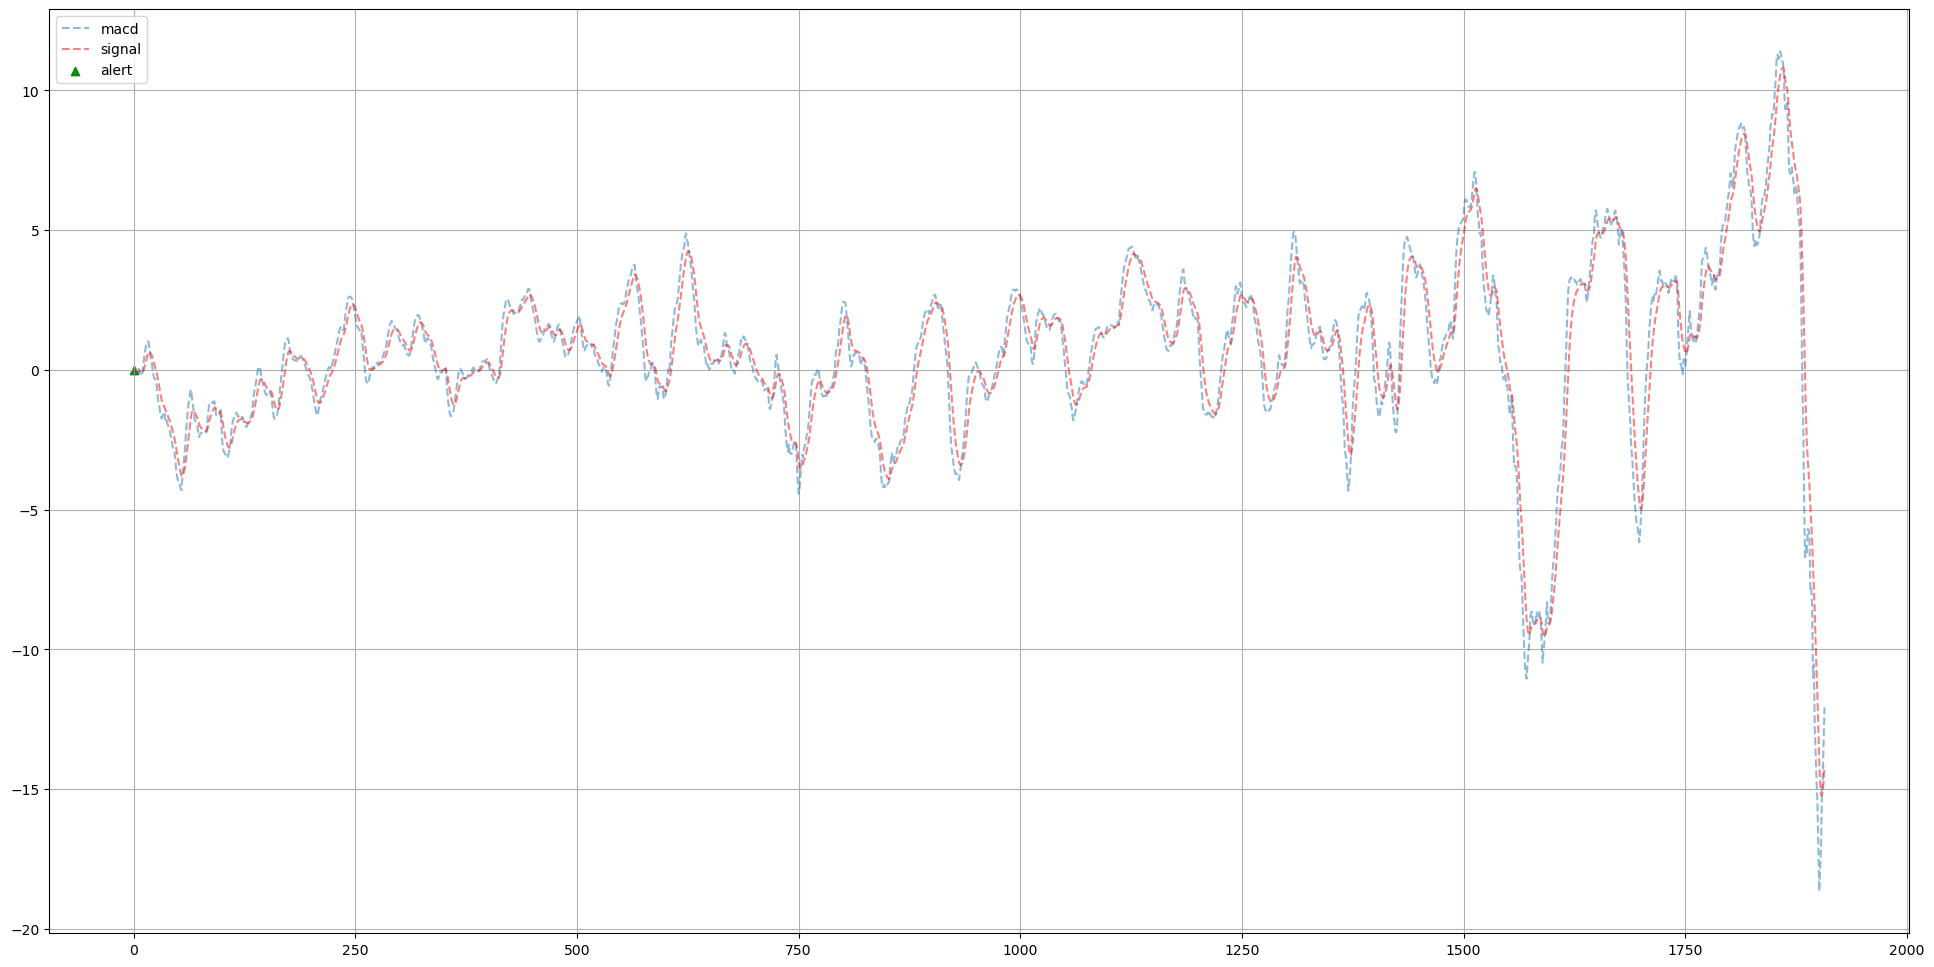

In [7]:
plt.figure(figsize=[24,12])
plt.grid(True)
plt.plot(strategy['MACD'],label='macd',alpha=0.5,linestyle='--')
plt.plot(strategy['SIGNAL'],label='signal',color='red',alpha=0.5,linestyle='--')
plt.scatter(x=strategy.index,y=strategy.trigger,marker='^',color='green',label='alert',alpha=0.9)
plt.legend(loc=2)

##### MACD

In [9]:
fig = px.bar(df, x=df.index, y=df.macd_difference_signal,color="mds_direction")
fig.show()
